# LoC Data Package Tutorial: Free to Use collection

This notebook will demonstrate basic usage of using Python for interacting with [data packages from the Library of Congress](https://data.labs.loc.gov/packages/) via the [Free to Use data package](https://data.labs.loc.gov/free-to-use/) which is derived from the Library's [Free to Use and Reuse Sets](https://loc.gov/free-to-use/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download and display images from a data package](#Download-and-display-images)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First, we will select [Free to Use Data Package](https://data.labs.loc.gov/free-to-use/) and output a summary of it's contents

In [1]:
import io

import pandas as pd                     # for reading, manipulating, and displaying data
import requests

from helpers import get_file_stats

DATA_URL = 'https://data.labs.loc.gov/free-to-use/' # Base URL of this data package

# Download the file manifest
file_manifest_url = f'{DATA_URL}manifest.json'
response = requests.get(file_manifest_url, timeout=60)
response_json = response.json()
files = [dict(zip(response_json["cols"], row)) for row in response_json["rows"]] # zip columns and rows

# Convert to Pandas DataFrame and show stats table
stats = get_file_stats(files)
pd.DataFrame(stats)

FileType  Count    Size
0     .jpg  2,610  1.06GB

## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular subject.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [2]:
metadata_url = f'{DATA_URL}metadata.json'
response = requests.get(metadata_url, timeout=60)
data = response.json()
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 2,610 entries.


Next let's convert to pandas DataFrame and print the available properties

In [3]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

Call_number, Contributors, Date_text, Date, Digitized, Set, Genre, Id, IIIF_manifest, Preview_url, Index, Other_title, Description, Creators, Type_of_resource, Location_text, Other_record_formats, Rights, Source_collection, Language, Lccn, Medium, Mime_type, Notes, Online_format, Original_format, Part_of, Repository, Number_of_files, Shelf_id, Subjects, Subject_headings, Last_updated_in_api, Title, Url, Location


Next print the top 10 most frequent Subjects in this dataset

In [4]:
# Since "Subjects" are a list, we must "explode" it so there's just one subject per row
# We convert to DataFrame so it displays as a table
df['Subjects'].explode().value_counts().iloc[:10].to_frame()

Subjects
united states             1073
color                      827
photographic prints        332
portrait photographs       265
america                    236
glass negatives            230
digital photographs        200
american                   166
washington (d.c.)          153
new york (state)           143

Now we filter the results to only those items with subject "washington (d.c.)"

In [12]:
df_by_subject = df.explode('Subjects')
dc_set = df_by_subject[df_by_subject.Subjects == 'washington (d.c.)']
print(f'Found {dc_set.shape[0]:,} items with subject "washington (d.c.)"')

Found 153 items with subject "washington (d.c.)"


## Download and display images

First we will merge the metadata with the file manifest to link the file URL to the respective item.

In [14]:
df_files = pd.DataFrame(files)
dc_set_with_images = pd.merge(dc_set, df_files, left_on='Id', right_on='item_id', how='inner')
print(f'Found {dc_set_with_images.shape[0]:,} dc items with image files')

Found 153 dc items with image files


Finally we will download and display the first 4 images that have subject "washington (d.c.)"

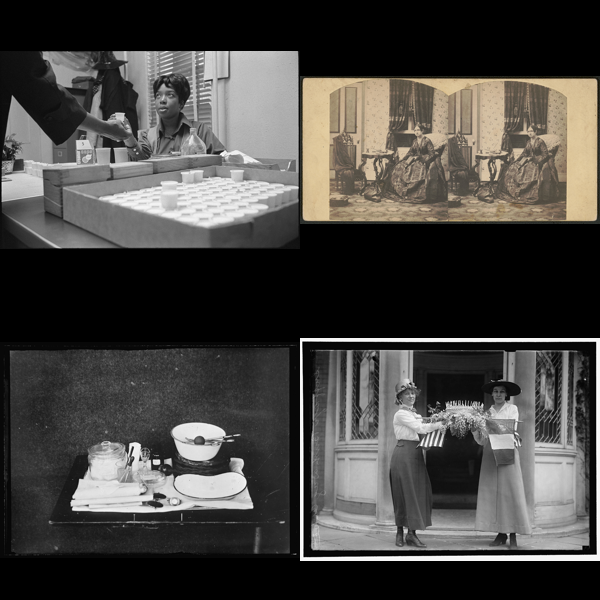

In [11]:
import math

from IPython.display import display     # for displaying images
from PIL import Image                   # for creating, reading, and manipulating images

count = 4
dc_set_with_images = dc_set_with_images.head(count).reset_index()

# Define image dimensions
image_w = 600
image_h = 600
cols = math.ceil(count / 2.0)
rows = math.ceil(count / 2.0)
cell_w = image_w / cols
cell_h = image_h / rows

# Create base image
base_image = Image.new("RGB", (image_w, image_h))

# Loop through image URLs
for i, row in dc_set_with_images.iterrows():
    file_url = f'https://{row["object_key"]}'

    # Downoad the image to memory
    response = requests.get(file_url, timeout=60)
    image_filestream = io.BytesIO(response.content)

    # And read the image data
    im = Image.open(image_filestream)

    # Resize it as a thumbnail
    im.thumbnail((cell_w, cell_h))
    tw, th = im.size

    # Position it
    col = i % cols
    row = int(i / cols)
    offset_x = int((cell_w - tw) * 0.5) if tw < cell_w else 0
    offset_y = int((cell_h - th) * 0.5) if th < cell_h else 0
    x = int(col * cell_w + offset_x)
    y = int(row * cell_h + offset_y)

    # Paste it
    base_image.paste(im, (x, y))

# Display the result
display(base_image)